# Project 2 - Clustering

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [197]:
df = pd.read_csv('toprich2024.csv')
df

,Rank,Name,Total net worth,$ Last change,$ YTD change,Country / Region,Industry
0,1,Elon Musk,$447B,+$62.8B,+$218B,United States,Technology
1,2,Jeff Bezos,$249B,+$4.65B,+$72.1B,United States,Technology
2,3,Mark Zuckerberg,$224B,+$4.58B,+$95.5B,United States,Technology
3,4,Larry Ellison,$198B,+$1.63B,+$75.3B,United States,Technology
4,5,Bernard Arnault,$181B,+$1.32B,-$26.4B,France,Consumer
...,...,...,...,...,...,...,...
495,496,Igor Bukhman,$6.41B,-$27.0M,+$2.86B,Israel,Technology
496,497,Dmitry Bukhman,$6.41B,-$27.0M,+$2.86B,Israel,Technology
497,498,Renate Reimann-Haas,$6.38B,$0,+$2.35B,Austria,Retail
498,499,Matthias Reimann-Andersen,$6.38B,$0,+$2.35B,Austria,Retail


## Pre-processing

In [199]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Rank', 'Name', 'Total net worth', '$ Last change', '$ YTD change',
       'Country / Region', 'Industry'],
      dtype='object')


In [201]:
df.isnull().sum() #check for nulls

Rank                0
Name                0
Total net worth     0
$ Last change       0
$ YTD change        0
Country / Region    0
Industry            0
dtype: int64

In [203]:
duplicates = df[df.duplicated()] #check for duplicates
duplicates #no duplicates

,Rank,Name,Total net worth,$ Last change,$ YTD change,Country / Region,Industry


### remove $ and special characters from numeric value while preserving value

In [205]:
print(df.dtypes)

Rank                 int64
Name                object
Total net worth     object
$ Last change       object
$ YTD change        object
Country / Region    object
Industry            object
dtype: object


In [217]:
# Convert strings with suffixes (B, M, K) into numerical values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '').strip()  # Remove $ and commas
        if value.startswith('+') or value.startswith('-'):
            value = value[1:]  # Remove the '+' or '-' sign for conversion
        
        # Check if value ends with 'B', 'M', or 'K' and convert while preserving value
        if value.endswith('B'):
            return float(value[:-1]) * 1e9 
        elif value.endswith('M'):
            return float(value[:-1]) * 1e6  # Convert millions to numeric
        elif value.endswith('k'):
            return float(value[:-1]) * 1e3  # Convert thousands to numeric
        else:
            try:
                return float(value)
            except ValueError:
                return value
    return value

# Clean and convert 'Total net worth' column to float if it's not already numeric
if df['Total net worth'].dtype == 'object':
    df['Total net worth'] = (
        df['Total net worth']
        .str.replace(r'[\$,B]', '', regex=True)  
        .str.replace(',', '')                  
        .astype(float)                          
    )

# Clean and convert '$ Last change' and '$ YTD change' columns
df['$ Last change'] = df['$ Last change'].apply(convert_to_number)
df['$ YTD change'] = df['$ YTD change'].apply(convert_to_number)
df

,Rank,Name,Total net worth,$ Last change,$ YTD change,Country / Region,Industry
0,1,Elon Musk,447.00,6.280000e+10,2.180000e+11,United States,Technology
1,2,Jeff Bezos,249.00,4.650000e+09,7.210000e+10,United States,Technology
2,3,Mark Zuckerberg,224.00,4.580000e+09,9.550000e+10,United States,Technology
3,4,Larry Ellison,198.00,1.630000e+09,7.530000e+10,United States,Technology
4,5,Bernard Arnault,181.00,1.320000e+09,2.640000e+10,France,Consumer
...,...,...,...,...,...,...,...
495,496,Igor Bukhman,6.41,2.700000e+07,2.860000e+09,Israel,Technology
496,497,Dmitry Bukhman,6.41,2.700000e+07,2.860000e+09,Israel,Technology
497,498,Renate Reimann-Haas,6.38,0.000000e+00,2.350000e+09,Austria,Retail
498,499,Matthias Reimann-Andersen,6.38,0.000000e+00,2.350000e+09,Austria,Retail


## Visualizations

In [209]:
print(df.columns)

Index(['Rank', 'Name', 'Total net worth', '$ Last change', '$ YTD change',
       'Country / Region', 'Industry'],
      dtype='object')


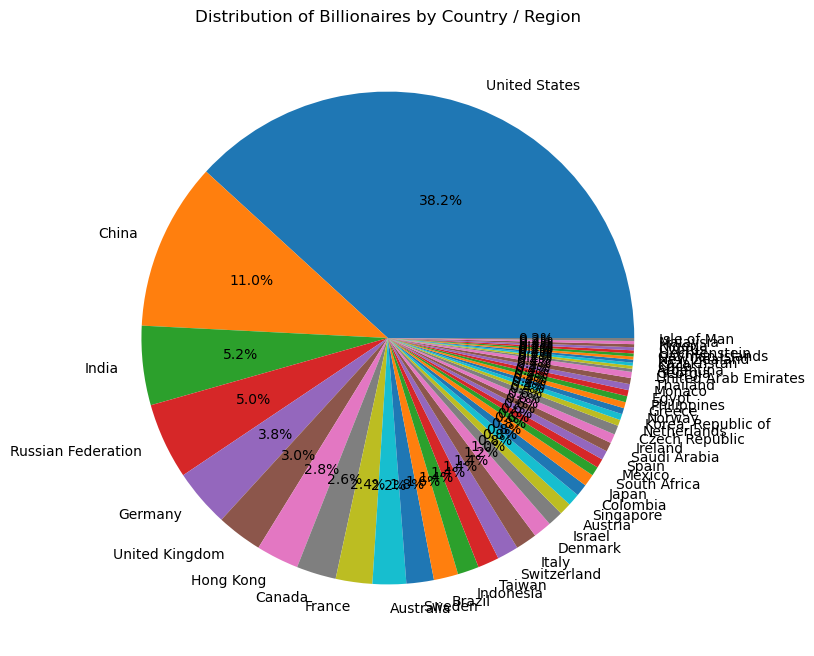

In [211]:
df['Country / Region'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8)) 
plt.title('Distribution of Billionaires by Country / Region') 
plt.ylabel('')
plt.show()

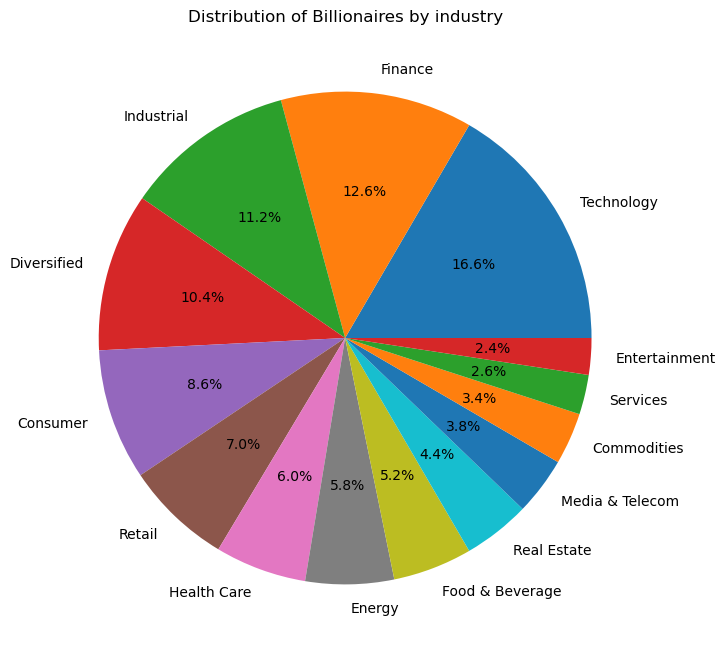

In [191]:
df['Industry'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8)) 
plt.title('Distribution of Billionaires by industry') 
plt.ylabel('')
plt.show()

## Modeling

C:\Users\sampa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


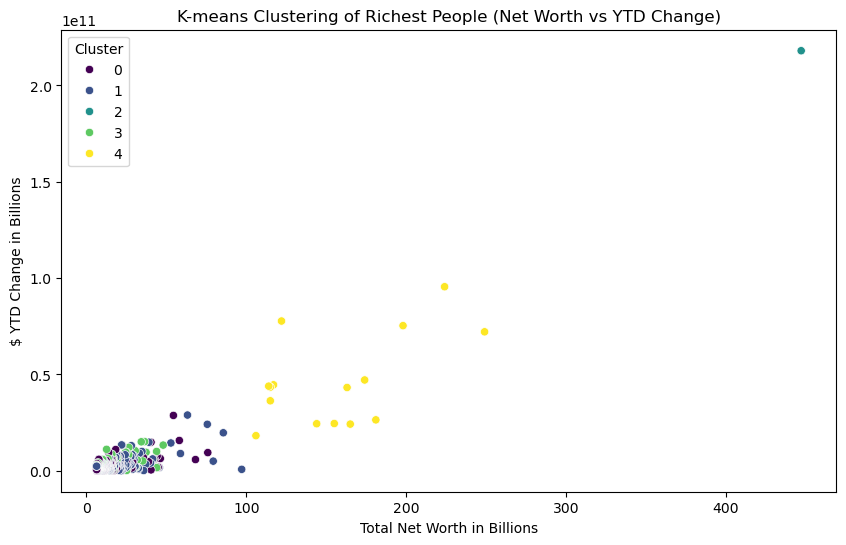

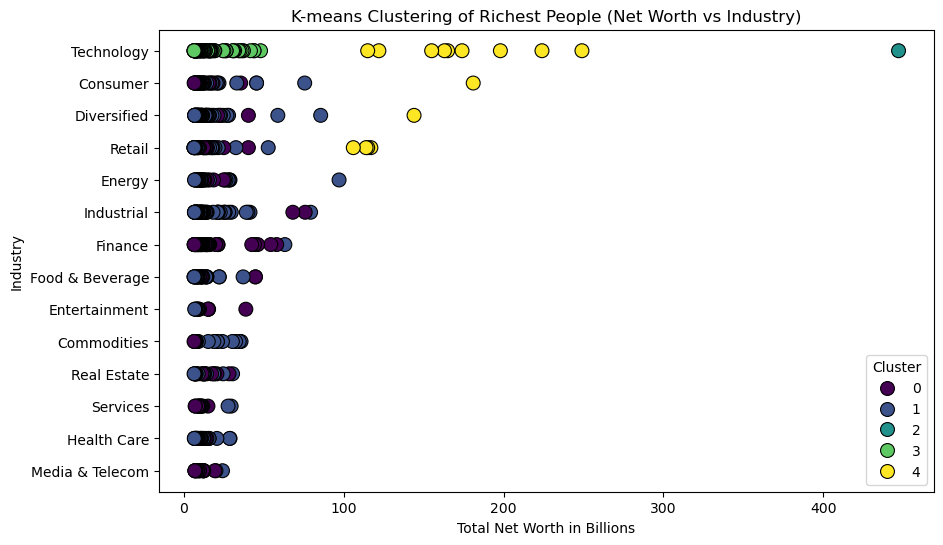

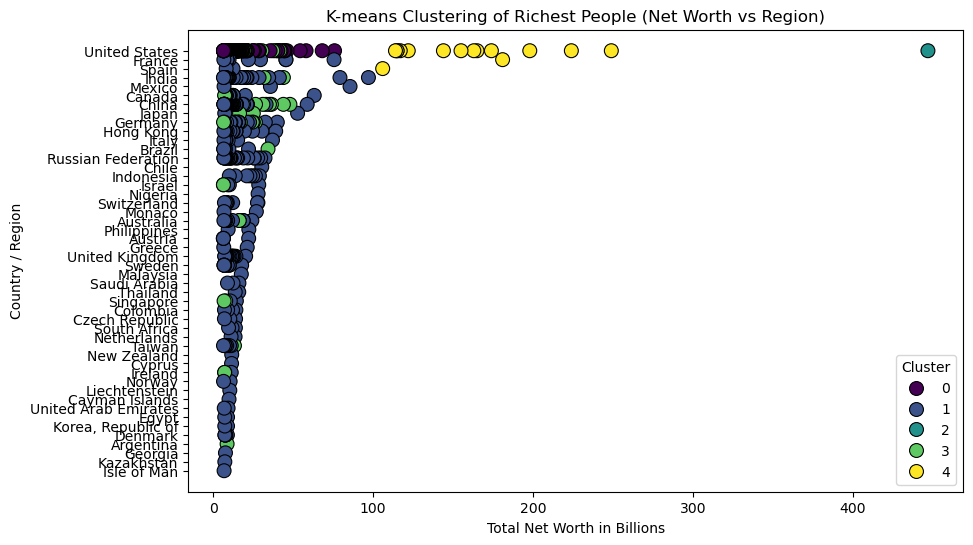

In [257]:
import os

os.environ["OMP_NUM_THREADS"] = "2"

df = df.dropna(subset=['Total net worth', '$ YTD change', 'Country / Region', 'Industry'])

df_encoded = pd.get_dummies(df[['Country / Region', 'Industry']], drop_first=True)

X = pd.concat([df[['Total net worth', '$ YTD change']], df_encoded], axis=1)

scaler = StandardScaler()
X[['Total net worth', '$ YTD change']] = scaler.fit_transform(X[['Total net worth', '$ YTD change']])

# K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualization of K-means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total net worth', y='$ YTD change', hue='Cluster', palette='viridis')
plt.title('K-means Clustering of Richest People (Net Worth vs YTD Change)')
plt.xlabel('Total Net Worth in Billions')
plt.ylabel('$ YTD Change in Billions')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total net worth', y='Industry', hue='Cluster', palette='viridis', s=100, edgecolor='black')
plt.title('K-means Clustering of Richest People (Net Worth vs Industry)')
plt.xlabel('Total Net Worth in Billions')
plt.ylabel('Industry')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total net worth', y='Country / Region', hue='Cluster', palette='viridis', s=100, edgecolor='black')
plt.title('K-means Clustering of Richest People (Net Worth vs Region)')
plt.xlabel('Total Net Worth in Billions')
plt.ylabel('Country / Region')
plt.show()

## Evaluation

In [259]:
print("Inertia:", kmeans.inertia_)


Inertia: 829.0071721481467


In [261]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.14064586679087557
